In [1]:
import jax

In [2]:
import os
import muon
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import scanpy as sc

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/

In [3]:
mudata = muon.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/mudata_with_annotation_all.h5mu")

In [4]:
cc_genes_macosko = pd.read_table('/lustre/groups/ml01/workspace/moscot_paper/pancreas/Macosko_cell_cycle_genes.txt', delimiter='\t')
def capitalize_first_letter(word):
    if pd.notna(word):
        return word.capitalize()
    else:
        return None

for column in cc_genes_macosko.columns:
    cc_genes_macosko[column] = cc_genes_macosko[column].apply(lambda x: capitalize_first_letter(x))


In [5]:
s_genes_macosko = list(mudata["rna"].var_names[np.isin(mudata["rna"].var_names, cc_genes_macosko['S'].dropna())])
g2m_genes_macosko = list(mudata["rna"].var_names[np.isin(mudata["rna"].var_names, cc_genes_macosko['G2.M'].dropna())])
m_genes_macosko = list(mudata["rna"].var_names[np.isin(mudata["rna"].var_names, cc_genes_macosko['M'].dropna())])
mg1_genes_macosko = list(mudata["rna"].var_names[np.isin(mudata["rna"].var_names, cc_genes_macosko['M.G1'].dropna())])
g1s_genes_macosko = list(mudata["rna"].var_names[np.isin(mudata["rna"].var_names, cc_genes_macosko['IG1.S'].dropna())])

In [6]:
cc_genes_macosko

,IG1.S,S,G2.M,M,M.G1,Unnamed: 5
0,Acd,Abcc5,Anln,Ahi1,agfg1,None
1,Acyp1,Abhd10,Ap3d1,Akirin2,Agpat3,None
2,Adamts1,Ankrd18a,Arhgap19,Ankrd40,Akap13,None
3,Ankrd10,Asf1b,Arl4a,Anln,Amd1,None
4,Apex2,Atad2,Armc1,Anp32b,Anp32e,None
...,...,...,...,...,...,...
146,None,None,None,Ywhah,None,None
147,None,None,None,Zc3hc1,None,None
148,None,None,None,Zfx,None,None
149,None,None,None,Zmym1,None,None


In [7]:
len(s_genes_macosko), len(g2m_genes_macosko), len(m_genes_macosko), len(mg1_genes_macosko), len(g1s_genes_macosko)

(99, 123, 140, 99, 92)

In [8]:
adata = mudata["rna"].copy()

In [9]:
adata = mudata["rna"]
adata.obsm["X_MultiVI"] = mudata.obsm["X_MultiVI"]
adata.obsm["X_umap"] = mudata.obsm["X_umap"]
adata.obs["cell_type_refined"] = mudata.obs["cell_type_refined"]

In [10]:
def adapt_time(x):
    if x["stage"]=="E14.5":
        return 14.5
    if x["stage"]=="E15.5":
        return 15.5
    if x["stage"]=="E16.5":
        return 16.5
    raise ValueError

adata.obs['time'] = adata.obs.apply(adapt_time, axis=1)

In [11]:
adata = adata[~adata.obs["cell_type"].isin(["Mat. Acinar", "Imm. Acinar"])]

In [12]:
dfs = {}
batch_column = "time"
unique_batches = [14.5, 15.5, 16.5]
for i in range(len(unique_batches) - 1):
    batch1 = unique_batches[i]
    batch2 = unique_batches[i + 1]

    indices = np.where((adata.obs[batch_column] == batch1) | (adata.obs[batch_column] == batch2))[0]
    adata_subset = adata[indices]
    sc.pp.neighbors(adata_subset, use_rep="X_MultiVI")
    dfs[(batch1, batch2)] = (
        pd.DataFrame(
            index=adata_subset.obs_names,
            columns=adata_subset.obs_names,
            data=adata_subset.obsp["connectivities"].A.astype("float64")
        )
    )

In [13]:
adata.obs["time"] = adata.obs["time"].astype("category")

/tmp/ipykernel_1807388/3091254131.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["time"] = adata.obs["time"].astype("category")


In [14]:
from moscot.problems.time import TemporalProblem
tp0 = TemporalProblem(adata)
tp0 = tp0.score_genes_for_marginals("mouse", "mouse")
tp0 = tp0.prepare("time", joint_attr="X_MultiVI", marginal_kwargs={"scaling": 1.0})

In [15]:
tp0[14.5, 15.5].set_graph_xy(dfs[14.5, 15.5], t=100)
tp0[15.5, 16.5].set_graph_xy(dfs[15.5, 16.5], t=100)

In [16]:
tp0.solve(max_iterations=1e7, device='cpu', tau_a=0.99, tau_b=0.99)

INFO     Solving `2` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(7404, 2213)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(7665, 7404)].                                  


TemporalProblem[(15.5, 16.5), (14.5, 15.5)]

In [17]:
adata = adata[adata.obs["cell_type"].isin(["Prlf. Ductal"])].copy()

In [18]:
len(adata)

1920

In [19]:
adata.X = adata.layers["raw_counts"]

In [20]:
sc.pp.normalize_total(adata)

In [21]:
sc.pp.log1p(adata)

In [22]:
adata = adata[:, adata.var_names.isin(cc_genes_macosko.values.flatten().tolist())]

In [23]:
adata.n_vars


509

In [24]:
adata_s = adata[:,adata.var_names.isin(s_genes_macosko)].copy()
adata_g1s = adata[:,adata.var_names.isin(g1s_genes_macosko)].copy()
adata_mg1 = adata[:,adata.var_names.isin(mg1_genes_macosko)].copy()
adata_m = adata[:,adata.var_names.isin(m_genes_macosko)].copy()
adata_g2m = adata[:,adata.var_names.isin(g2m_genes_macosko)].copy()

In [25]:
adata_s.obs["mean_expr"] = adata_s.X.mean(axis=1)
adata_g1s.obs["mean_expr"] = adata_g1s.X.mean(axis=1)
adata_mg1.obs["mean_expr"] = adata_mg1.X.mean(axis=1)
adata_m.obs["mean_expr"] = adata_m.X.mean(axis=1)
adata_g2m.obs["mean_expr"] = adata_g2m.X.mean(axis=1)

In [26]:
adata_s.var[f"correlation_s"] = np.apply_along_axis(lambda x: stats.pearsonr(x, adata_s.obs["mean_expr"]), 0, adata_s.X.A)[0,:]
adata_g1s.var[f"correlation_g1s"] = np.apply_along_axis(lambda x: stats.pearsonr(x, adata_g1s.obs["mean_expr"]), 0, adata_g1s.X.A)[0,:]
adata_mg1.var[f"correlation_mg1"] = np.apply_along_axis(lambda x: stats.pearsonr(x, adata_mg1.obs["mean_expr"]), 0, adata_mg1.X.A)[0,:]
adata_m.var[f"correlation_m"] = np.apply_along_axis(lambda x: stats.pearsonr(x, adata_m.obs["mean_expr"]), 0, adata_m.X.A)[0,:]
adata_g2m.var[f"correlation_g2m"] = np.apply_along_axis(lambda x: stats.pearsonr(x, adata_g2m.obs["mean_expr"]), 0, adata_g2m.X.A)[0,:]

In [27]:
adata_s.n_vars, adata_g1s.n_vars, adata_mg1.n_vars, adata_m.n_vars, adata_g2m.n_vars


(99, 92, 99, 140, 123)

In [28]:
adata_s = adata_s[:, (np.abs(adata_s.var[f"correlation_s"])>=0.2)]
adata_g1s = adata_g1s[:, (np.abs(adata_g1s.var[f"correlation_g1s"])>=0.2)]
adata_mg1 = adata_mg1[:, (np.abs(adata_mg1.var[f"correlation_mg1"])>=0.2)]
adata_m = adata_m[:, (np.abs(adata_m.var[f"correlation_m"])>=0.2)]
adata_g2m = adata_g2m[:, (np.abs(adata_g2m.var[f"correlation_g2m"])>=0.2)]


In [29]:
adata_s.n_vars, adata_g1s.n_vars, adata_mg1.n_vars, adata_m.n_vars, adata_g2m.n_vars


(31, 43, 31, 72, 61)

In [30]:
A = np.concatenate((adata_s.X.mean(axis=1), adata_g1s.X.mean(axis=1), adata_mg1.X.mean(axis=1), adata_m.X.mean(axis=1), adata_g2m.X.mean(axis=1)), axis=1)


In [31]:
A.shape


(1920, 5)

In [32]:
adata.n_obs

1920

In [33]:
import scipy
A_norm = scipy.stats.zscore(np.array(A))

In [34]:
cols = ["expr_g1s", "expr_s","expr_g2m", "expr_m", "expr_mg1"]

In [35]:
adata.obs[cols] = A_norm

/tmp/ipykernel_1807388/368601202.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[cols] = A_norm


In [36]:
adata.obs["phase_first"] = adata.obs[cols].idxmax(axis=1)

In [37]:
adata.obs["phase_first"].value_counts()

phase_first
expr_s      562
expr_g1s    424
expr_g2m    351
expr_m      294
expr_mg1    289
Name: count, dtype: int64

In [38]:
def get_second_largest_column(row):
    sorted_row = sorted(row.items(), key=lambda x: x[1], reverse=True)
    return sorted_row[1][0]

adata.obs["phase_second"] = adata.obs[cols].apply(get_second_largest_column, axis=1)

In [39]:
phase_dict = {"expr_g1s": 1, "expr_s":2, "expr_g2m": 3, "expr_m": 4, "expr_mg1":5}

In [40]:
adata.obs["phase_numeric_1"] = adata.obs["phase_first"].map(phase_dict)

In [41]:
adata.obs["phase_numeric_2"] = adata.obs["phase_second"].map(phase_dict)

In [42]:
adata.obs["phase_diff"] = np.abs(adata.obs["phase_numeric_2"] - adata.obs["phase_numeric_1"])

In [43]:
adata.obs["phase_diff"].value_counts()

phase_diff
1    1593
2     239
4      47
3      41
Name: count, dtype: int64

In [44]:
adata.n_obs

1920

In [45]:
adata_red = adata[adata.obs["phase_diff"].isin((1,4))]

In [46]:
adata_red.obs["phase_first"].value_counts()

phase_first
expr_s      541
expr_g1s    374
expr_m      283
expr_mg1    227
expr_g2m    215
Name: count, dtype: int64

In [47]:
def get_largest_value(x):
    return x[x["phase_first"]]
adata_red.obs["phase_first_value"] = adata_red.obs.apply(get_largest_value, axis=1)

/tmp/ipykernel_1807388/253259611.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_red.obs["phase_first_value"] = adata_red.obs.apply(get_largest_value, axis=1)


In [48]:
def get_second_largest_value(x):
    return x[x["phase_second"]]
adata_red.obs["phase_second_value"] = adata_red.obs.apply(get_second_largest_value, axis=1)

In [49]:
adata_red.n_obs

1640

In [50]:
adata_red2 = adata_red[adata_red.obs["phase_second_value"]<=0.7] # 0.7

In [51]:
adata_red2.n_obs, adata_red2.obs["phase_first"].value_counts()

(790,
 phase_first
 expr_s      337
 expr_g1s    185
 expr_mg1    101
 expr_m       92
 expr_g2m     75
 Name: count, dtype: int64)

In [52]:
adata_red3 = adata_red2[adata_red2.obs["phase_first_value"]>=0.5]


In [53]:
adata_red3.n_obs

587

In [54]:
adata_red3.obs["index"] = adata_red3.obs.index
tp0.adata.obs["index"] = tp0.adata.obs_names

/tmp/ipykernel_1807388/1663559947.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_red3.obs["index"] = adata_red3.obs.index


In [55]:
def get_phase(x):
    if x["index"] in adata_red3.obs_names:
        return adata_red3.obs.loc[x["index"], "phase_first"]
    return None
tp0.adata.obs["phase_first"] = tp0.adata.obs.apply(get_phase, axis=1).astype("category")

In [56]:
tp0.adata.obs["phase_first"].value_counts()

phase_first
expr_s      236
expr_g1s    161
expr_mg1     72
expr_m       64
expr_g2m     54
Name: count, dtype: int64

In [57]:
df_early = tp0.cell_transition(14.5, 15.5, "phase_first", "phase_first", forward=True)

In [58]:
df_late = tp0.cell_transition(15.5, 16.5, "phase_first", "phase_first", forward=True)

In [59]:
df_late

,expr_s,expr_m,expr_mg1,expr_g1s,expr_g2m
expr_s,0.887251,0.004458,0.003141,0.103653,0.001498
expr_m,0.120528,0.321529,0.154378,0.324214,0.079351
expr_g1s,0.574058,0.013144,0.008287,0.400449,0.004063
expr_mg1,0.147301,0.172965,0.099620,0.530254,0.049860
expr_g2m,0.158642,0.220476,0.117759,0.429188,0.073934


In [60]:
d = {"expr_g1s": 1, "expr_s":2, "expr_g2m": 3, "expr_m": 4, "expr_mg1":5}

In [61]:
data = np.array([
    [0, 1, 0, 0, -1],
    [-1, 0, 1, 0, 0],
    [0, -1, 0, 1, 0],
    [0, 0, -1, 0, 1],
    [1, 0, 0, -1, 0]
])
data

array([[ 0,  1,  0,  0, -1],
       [-1,  0,  1,  0,  0],
       [ 0, -1,  0,  1,  0],
       [ 0,  0, -1,  0,  1],
       [ 1,  0,  0, -1,  0]])

In [62]:
df_reference = pd.DataFrame(data, columns=d.keys(), index=d.keys())
df_reference

,expr_g1s,expr_s,expr_g2m,expr_m,expr_mg1
expr_g1s,0,1,0,0,-1
expr_s,-1,0,1,0,0
expr_g2m,0,-1,0,1,0
expr_m,0,0,-1,0,1
expr_mg1,1,0,0,-1,0


In [63]:
df_early = df_early[df_reference.columns]
df_early = df_early.loc[df_reference.index] 

In [64]:
df_early.index == df_reference.index, df_early.index == df_reference.index


(array([ True,  True,  True,  True,  True]),
 array([ True,  True,  True,  True,  True]))

In [65]:
stat_early = (df_early.values*df_reference.values).sum()
stat_early

0.7161679672832135

In [66]:
def get_permuted_score(df, df_reference):
    matrix = np.zeros((5, 5))
    
    permuted_values = df.values.copy()
    non_diagonal_indices = np.where(~np.eye(df.shape[0], dtype=bool))
    permuted_values = np.random.permutation(permuted_values[non_diagonal_indices])
    
    # Define the values you want to fill the diagonal and non-diagonal elements with
    diagonal_value = np.diag(df)
    non_diagonal_value = np.nan
    
    # Fill the diagonal with the diagonal_value
    np.fill_diagonal(matrix, diagonal_value)
    
    # Fill all other values except the diagonal with the non_diagonal_value
    matrix[~np.eye(matrix.shape[0], dtype=bool)] = permuted_values

    return (matrix*df_reference.values).sum()




In [67]:
res_early = []
for i in range(10_000):
    res_early.append(get_permuted_score(df_early, df_reference))

In [68]:
(res_early < stat_early).sum()/len(res_early)

0.8779

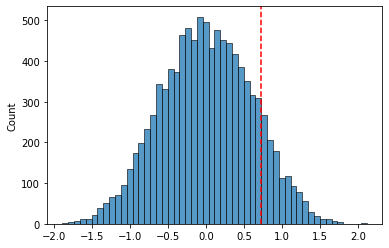

In [69]:
import matplotlib.pyplot as plt

sns.histplot(res_early)
plt.axvline(x=stat_early, color='r', linestyle='--')

In [70]:
df_late = df_late[df_reference.columns]
df_late = df_late.loc[df_reference.index] 

In [71]:
df_early.index == df_reference.index, df_early.index == df_reference.index


(array([ True,  True,  True,  True,  True]),
 array([ True,  True,  True,  True,  True]))

In [72]:
stat_late = (df_late.values*df_reference.values).sum()
stat_late


0.957767086335938

In [73]:
res_late = []
for i in range(10_000):
    res_late.append(get_permuted_score(df_late, df_reference))

In [74]:
(res_late < stat_late).sum()/len(res_late)

0.9587

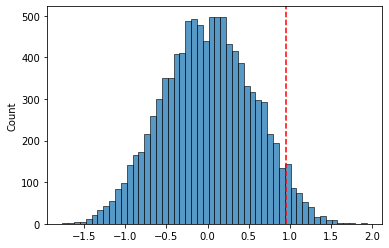

In [75]:
sns.histplot(res_late)
plt.axvline(x=stat_late, color='r', linestyle='--')

In [76]:
mudata["rna"].obs["cell_cycle"] = tp0.adata.obs["phase_first"]

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


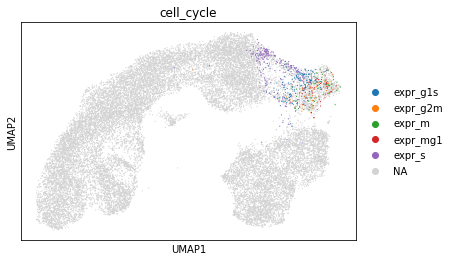

In [78]:
sc.pl.umap(mudata["rna"], color="cell_cycle")

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


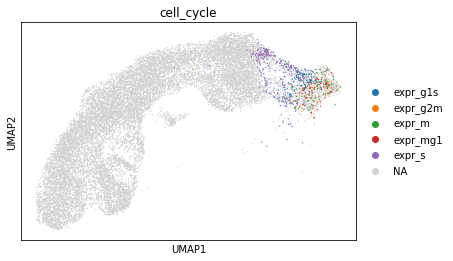

In [79]:
sc.pl.umap(mudata[~mudata.obs["cell_type"].isin(("Imm. Acinar", "Mat. Acinar"))]["rna"], color="cell_cycle")